# Does New Metric Solve the Early Year Instability Problem?

Early year models are unstable as there isn't a whole lot of data to appropriately train a word2vec model. [04_novel_distance_calculations](04_novel_distance_calculations.ipynb) notebook was designed to create a metric that can account for this problem.
This notebook is designed to test if the newly constructed metric actually fixes the problem via a global comparison using all tokens present in 2000 through 2020.

In [1]:
from pathlib import Path
import re

import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
import tqdm

# Load distances for all Year Pairs

## Load the years for metric fix

In [2]:
subsetted_tokens = pd.read_csv("output/subsetted_tokens.tsv", sep="\t")
token_filter_list = subsetted_tokens.tok.tolist()
subsetted_tokens.head()

,tok
0,united
1,combining
2,purinergic
3,decomposition
4,60.0


In [3]:
distance_files = list(
    Path("output/combined_inter_intra_distances").rglob("saved_*_distance.tsv")
)
print(len(distance_files))

20


In [4]:
year_distance_map = {
    re.search(r"\d+", str(year_file)).group(0): (pd.read_csv(str(year_file), sep="\t"))
    for year_file in tqdm.tqdm(distance_files)
}

100%|██████████| 20/20 [00:01<00:00, 15.96it/s]


In [5]:
full_token_set_df = pd.concat(
    [
        year_distance_map[year] >> ply.query(f"tok in {token_filter_list}")
        for year in tqdm.tqdm(year_distance_map)
    ]
)
print(full_token_set_df.shape)
full_token_set_df.head()

100%|██████████| 20/20 [00:07<00:00,  2.56it/s]

(1090766, 7)


,tok,original_global_distance,global_distance_qst,local_distance_qst,ratio_metric,year_1,year_2
0,poly(adp,0.211844,0.522492,0.696891,1.094208,2009,2010
1,partners,0.159972,0.491531,0.625901,0.966688,2009,2010
2,permeation,0.280244,0.565166,0.694604,1.299729,2009,2010
3,137,0.385017,0.592415,0.782952,1.453473,2009,2010
4,sixty,0.170093,0.520045,0.578388,1.083528,2009,2010


## Load the first indexed model from each year to show the difference

In [6]:
all_inter_year_models = list(Path("output/inter_models").rglob("*tsv"))

In [7]:
regex_pattern = r"\d+_0-\d+_0"
all_inter_models_df = pd.concat(
    [
        pd.read_csv(str(file), sep="\t")
        >> ply.query(f"year_pair.str.contains({regex_pattern})")
        for file in all_inter_year_models
    ]
)
all_inter_models_df >> ply.slice_rows(15)

,tok,global_distance,local_distance,year_pair
687332,poly(adp,0.216282,0.010672,2013_0-2014_0
687333,partners,0.166323,0.003434,2013_0-2014_0
687334,permeation,0.191191,0.005083,2013_0-2014_0
687335,137,0.288401,0.001241,2013_0-2014_0
687336,sixty,0.151591,0.002123,2013_0-2014_0
687337,-0.4,0.301337,0.003242,2013_0-2014_0
687338,vigorously,0.740366,0.454352,2013_0-2014_0
687339,pdgf,0.325047,0.010923,2013_0-2014_0
687340,vesicular,0.242766,0.002579,2013_0-2014_0
687341,normalised,0.512075,0.041473,2013_0-2014_0


In [8]:
middle_estimate = (
    all_inter_models_df
    >> ply.query("year_pair=='2010_0-2011_0'")
    >> ply.pull("global_distance")
).mean()
middle_estimate

0.27639573139563356

In [9]:
regex_pattern = r"(\d+)_0-(\d+)_0"
percent_diff_one_year = (
    all_inter_models_df
    >> ply_tdy.extract(
        "year_pair", into=["year_1", "year_2"], regex=regex_pattern, convert=True
    )
    >> ply.group_by("year_1", "year_2")
    >> ply.query("year_2-year_1==1")
    >> ply.define(pct_diff="mean(global_distance)/middle_estimate - 1")
    >> ply.select("year_1", "year_2", "pct_diff")
    >> ply.ungroup()
    >> ply.distinct()
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
percent_diff_one_year

,year_pair,pct_diff
687332,2013_2014,-0.105728
33010,2004_2005,1.058588
1779102,2001_2002,0.853884
298840,2010_2011,0.000000
926404,2017_2018,-0.200996
1180418,2014_2015,-0.137971
406040,2000_2001,0.797143
164362,2019_2020,-0.129009
1090766,2015_2016,-0.162554
821810,2016_2017,-0.183588


# Does distance increase across the years?

## Calculate an average of all words for all trained Models

In [10]:
all_distance_df = (
    full_token_set_df
    >> ply.arrange("tok")
    >> ply.group_by("year_2")
    >> ply.define(
        avg_global_distance="mean(original_global_distance)",
        avg_global_distance_qst="mean(global_distance_qst)",
        avg_ratio_metric="mean(ratio_metric)",
    )
    >> ply.select(
        "avg_global_distance", "avg_global_distance_qst", "avg_ratio_metric", "year_1"
    )
    >> ply.distinct()
    >> ply.ungroup()
    >> ply.query("year_2-year_1==1")
    >> ply_tdy.unite("year_pair", "year_1", "year_2")
)
all_distance_df >> ply.slice_rows(15)

,year_pair,avg_global_distance,avg_global_distance_qst,avg_ratio_metric
4717,2009_2010,0.560118,0.697596,2.698475
4717,2014_2015,0.562471,0.696560,2.817352
9262,2001_2002,0.445456,0.657321,2.030712
4717,2010_2011,0.561994,0.696678,2.714570
4717,2012_2013,0.562731,0.696502,2.761310
38240,2005_2006,0.499808,0.698707,2.549750
4717,2015_2016,0.562108,0.696709,2.838701
4717,2007_2008,0.553410,0.715976,2.814265
46804,2006_2007,0.518487,0.706462,2.685561
4717,2008_2009,0.562355,0.705025,2.725759


In [11]:
global_qst_comparison = all_distance_df >> ply_tdy.gather(
    "metric",
    "distance_value",
    ply.select(
        "avg_global_distance_qst",
        "avg_global_distance",
        "avg_ratio_metric",
    ),
)
global_qst_comparison.year_pair = pd.Categorical(
    global_qst_comparison.year_pair.tolist()
)
global_qst_comparison.head(10)

,year_pair,metric,distance_value
0,2009_2010,avg_global_distance_qst,0.697596
1,2014_2015,avg_global_distance_qst,0.696560
2,2001_2002,avg_global_distance_qst,0.657321
3,2010_2011,avg_global_distance_qst,0.696678
4,2012_2013,avg_global_distance_qst,0.696502
5,2005_2006,avg_global_distance_qst,0.698707
6,2015_2016,avg_global_distance_qst,0.696709
7,2007_2008,avg_global_distance_qst,0.715976
8,2006_2007,avg_global_distance_qst,0.706462
9,2008_2009,avg_global_distance_qst,0.705025


In [12]:
middle_map = dict(
    global_qst_comparison
    >> ply.query("year_pair=='2010_2011'")
    >> ply.pull(["metric", "distance_value"])
)

In [13]:
pct_diff_df = (
    global_qst_comparison
    >> ply.arrange("year_pair")
    >> ply.define(
        pct_diff=ply.expressions.case_when(
            {
                'metric=="avg_global_distance_qst"': f'distance_value/{middle_map["avg_global_distance_qst"]} - 1',
                'metric=="avg_global_distance"': f'distance_value/{middle_map["avg_global_distance"]} - 1',
                'metric=="avg_ratio_metric"': f'distance_value/{middle_map["avg_ratio_metric"]} - 1',
            }
        )
    )
)
pct_diff_df

,year_pair,metric,distance_value,pct_diff
10,2000_2001,avg_global_distance_qst,0.654512,-0.060525
30,2000_2001,avg_global_distance,0.439978,-0.217113
50,2000_2001,avg_ratio_metric,2.011923,-0.258843
42,2001_2002,avg_ratio_metric,2.030712,-0.251921
2,2001_2002,avg_global_distance_qst,0.657321,-0.056492
22,2001_2002,avg_global_distance,0.445456,-0.207366
16,2002_2003,avg_global_distance_qst,0.663636,-0.047429
36,2002_2003,avg_global_distance,0.449486,-0.200195
56,2002_2003,avg_ratio_metric,2.100481,-0.226220
34,2003_2004,avg_global_distance,0.460253,-0.181037


## Plot the differences to see if metric eases some of the earlier year instability

This plot here is designed to show on a global scale the differences between my devised metrics in [04_novel_distance_calculations.ipynb](04_novel_distance_calculations.ipynb) and the traditional approach.
The dark colored lines are the three different metrics I devised (Qst, Qst * distance and Ratio).
The pink line is the traditional way where approaches only use one model per year and just align.

Overall, one can see that without a correction factor a lot of words in the earlier years will appear to be a lot different than words in later years (small amount of document availability).

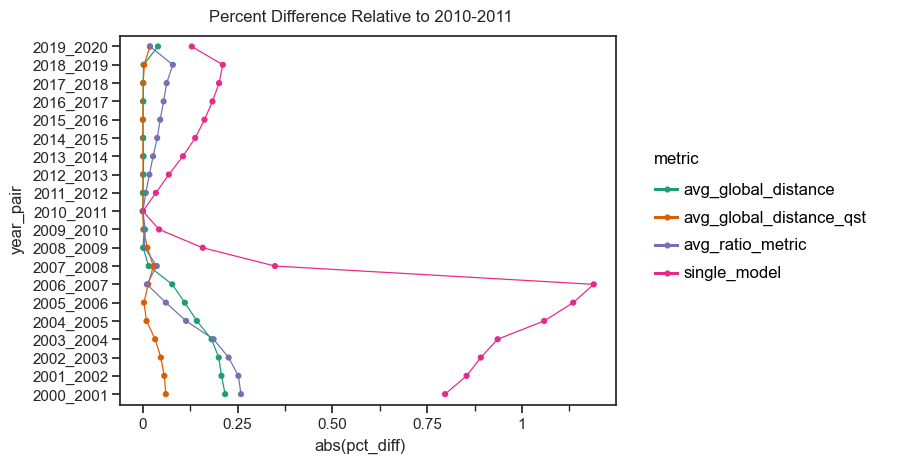

<ggplot: (8727629157566)>

In [14]:
(
    p9.ggplot(
        pct_diff_df
        >> ply.select("-distance_value")
        >> ply.call(
            ".append", percent_diff_one_year >> ply.define(metric='"single_model"')
        ),
        p9.aes(x="year_pair", y="abs(pct_diff)", group="metric", color="metric"),
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn(style="white")
    + p9.labs(title="Percent Difference Relative to 2010-2011")
    + p9.scale_color_brewer("qual", palette=2)
)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/early_year_correction_comparison.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/early_year_correction_comparison.png


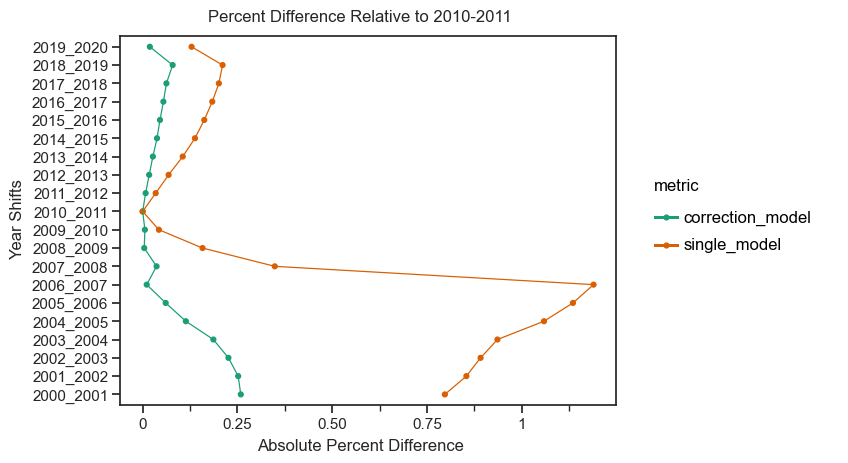

In [15]:
g = (
    p9.ggplot(
        pct_diff_df
        >> ply.select("-distance_value")
        >> ply.call(
            ".append", percent_diff_one_year >> ply.define(metric='"single_model"')
        )
        >> ply.query("metric=='single_model' or metric=='avg_ratio_metric'")
        >> ply.define(
            metric=ply.expressions.case_when(
                {'metric=="avg_ratio_metric"': '"correction_model"', True: "metric"}
            )
        ),
        p9.aes(x="year_pair", y="abs(pct_diff)", group="metric", color="metric"),
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn(style="white")
    + p9.labs(title="Percent Difference Relative to 2010-2011")
    + p9.scale_color_brewer("qual", palette=2)
    + p9.labs(x="Year Shifts", y="Absolute Percent Difference")
)
g.save("output/figures/early_year_correction_comparison.svg")
g.save("output/figures/early_year_correction_comparison.png", dpi=500)
print(g)

Take home Points:
1. All metrics (using more than one model, using the qst metric, using qst * original distance, using the ratio metric) in the first figure shows seem to improve early year bias. Not a drastic spike in absolute percent difference.
2. Still resorting to using the ratio metric as mentioned in previous notebook.
3. The last figure highlights a need for a correction metric as well. I filtered out the other metric ideas and only used the ratio metric (green) compared to the traditional metric (orange).